In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#imports section
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
from mvo_utils import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
# Global variables
log = True
refresh_pricing = False
universe = 'ark-etfs' # 'spy_sectors OR 'ark_etfs'
active_etf = None # ETF name OR None for broad market
#variables for performance analysis
frequency = "W-THU" # initial value for lookback
lb = 60; min_gross=0.5; max_gross=1; min_w=0; max_w=0.1 # default optimization vars

In [4]:
# load spy sector components
# would be nice to load a JSON with configuration
ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy-sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE'],
    'ark-etfs': ['ARKG', 'ARKK', 'ARKQ', 'ARKW']
}

config = {
    'spy-sectors' : {
        'hold_cols': ['Symbol','Company Name', 'Index Weight'],
        'hold_format': r'holdings-spy-',
        'idx_col': 'Symbol',
        'fname': 'spy-sectors',
        'skiprows': 1
    },
    'ark-etfs' : {
        'hold_cols': ['ticker','company', 'weight(%)'],
        'hold_format': r'holdings-ark-',
        'idx_col': 'ticker',
        'fname': 'ark-etfs',
        'skiprows': 0
    }
}

hold_cols = config[universe]['hold_cols']
hold_format = config[universe]['hold_format']
idx_col = config[universe]['idx_col']
fname = config[universe]['fname']
skiprows = config[universe]['skiprows']

companies = load_components(companies, hold_format, hold_cols, idx_col, ticker_map[universe], srows=skiprows)
print("Companies loaded:", companies.shape)
px_etfs = load_pricing(fname + '.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

Companies loaded: (179, 3)
Loaded pricing for ark-etfs.csv, with shape (69, 4)
Loaded pricing for SPY.csv, with shape (69, 1)


In [5]:
# load pricing
px_etfs = load_pricing(universe + '.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

Loaded pricing for ark-etfs.csv, with shape (69, 4)
Loaded pricing for SPY.csv, with shape (69, 1)


In [6]:
# Load pricing for components of each sectors
# Util function to load components for different benchmarks
def load_consol_px(tm_key):
    consol_px = pd.DataFrame([])
    for key in ticker_map[tm_key]:
        px = load_pricing(key + '-hold-pricing.csv', 'Date').copy()
        ccols = set(consol_px.columns.tolist())
        newcols = set(px.columns.tolist())
        consol_px = consol_px.merge(
            px[list(newcols.difference(ccols))], 
            left_index=True, 
            right_index=True, 
            how='outer')
    return consol_px

consol_px = clean_nas(load_consol_px(universe))
if(active_etf != None):
    companies = companies[companies['ETF']==active_etf] # filter by selected ETF
tickers = companies.index.tolist()
tickers=[i for i in tickers if i not in ['BF.b','BRK.b']] ## esta es una correcion extra para no incluir 'BF.b','BRK.b'
consol_px = consol_px[list(set(tickers))]

Loaded pricing for ARKG-hold-pricing.csv, with shape (69, 36)
Loaded pricing for ARKK-hold-pricing.csv, with shape (69, 55)
Loaded pricing for ARKQ-hold-pricing.csv, with shape (69, 45)
Loaded pricing for ARKW-hold-pricing.csv, with shape (69, 43)


In [175]:
# Removing tickers for M&A targets and diff class shares of same co.
remove_tickers = ['CSRA', 'DPS', 'UAA', 'DISCK', 'JUNO', 'XL', 'WELL', 'BKNG', 'SNI'] # example: two M&A targets, diff share classes...
remove = list(set(remove_tickers).intersection(consol_px.columns.tolist()))
if len(remove) > 0:
    consol_px.drop(remove, axis=1, inplace=True)

In [176]:
# range of potential gammas using logspace
SAMPLES = 100; gamma_vals = np.logspace(-2, 3, num=SAMPLES)

In [177]:
c_px, t_w, lb, f, mi_g, ma_g, mi_w, ma_w = consol_px, hist_window, lb, frequency, min_gross, max_gross, min_w, max_w

In [188]:
# Finds the best gamma risk parameter, current apprahc
def curr_gammas(c_px, t_w, lb, f, mi_g, ma_g, mi_w, ma_w):
    opt_cols = ["Return", "Risk", "Sharpe"]
    opt_df = pd.DataFrame([], index=gamma_vals, columns=opt_cols)
    for i in gamma_vals:
        px_p, _, alloc, pdf = recommend_allocs(c_px, t_w, lb, f, mi_g, ma_g, mi_w, ma_w, i)
        rec = last_allocation(alloc, 0.01)
        ret, risk = port_metrics(px_p, rec)
        opt_df.loc[i][opt_cols] = [ret, risk, ret / risk]
    return opt_df, pdf

# return portfolio sharpe for a given optimization
def get_sr_for_opt(c_px, t_w, lb, f, mi_g, ma_g, mi_w, ma_w, gamma):
    px_p, _, alloc, pdf = recommend_allocs(c_px, t_w, lb, f, mi_g, ma_g, mi_w, ma_w, gamma)
    rec = last_allocation(alloc, 0.01)
    ret, risk = port_metrics(px_p, rec)
    return ret / risk

In [183]:
# test sharpe for gamma = 1
get_sr_for_opt(c_px, t_w, lb, f, mi_g, ma_g, mi_w, ma_w, 1)

1.1274500180807567

In [181]:
# new quick gamma approach
# pending implementation using partials
def quick_gamma(glist):
    if len(glist) <= 1: 
        mid_g = glist[0]
        mid_sr = get_sr_for_opt(c_px, t_w, lb, f, mi_g, ma_g, mi_w, ma_w, mid_g)
        return mid_g, mid_sr
    else:
        mid = len(glist)//2; left = glist[:mid]; right = glist[mid:]
        mid_l = left[len(left)//2]; mid_r = right[len(right)//2]
        left_sr = get_sr_for_opt(c_px, t_w, lb, f, mi_g, ma_g, mi_w, ma_w, mid_l)
        right_sr = get_sr_for_opt(c_px, t_w, lb, f, mi_g, ma_g, mi_w, ma_w, mid_r)
        if left_sr > right_sr: sublist = left
        else: sublist = right
        return quick_gamma(sublist)

In [185]:
# time for recursive approach
# prints gamma, sharpe ratio of portfolio
%time print(quick_gamma(gamma_vals))

(21.544346900318846, 1.773990079145451)
CPU times: user 7.62 s, sys: 66.1 ms, total: 7.69 s
Wall time: 3.88 s


In [ ]:
# time for iterative approach => current apprach, this is what curr_gammas do
%time res = [(x, get_sr_for_opt(c_px, t_w, lb, f, mi_g, ma_g, mi_w, ma_w, x)) for x in gamma_vals]

In [ ]:
# turn into numpy
gamma_srs = np.array(res).T
# finds largest sharpe ratio
res[np.argmax(gamma_srs[1])]

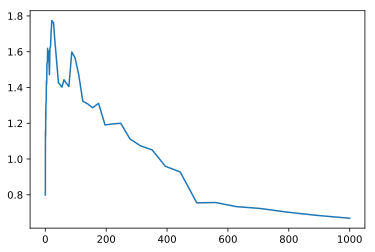

In [165]:
# plots gamma to sharpe ratio
plt.plot(gamma_srs[0], gamma_srs[1])

In [190]:
opt_df, pdf = curr_gammas(c_px, t_w, lb, f, mi_g, ma_g, mi_w, ma_w)
top = 5; best_gamma_ports = opt_df.sort_values(by='Sharpe', ascending=False).head(top)
top_gammas = best_gamma_ports.index.tolist(); gamma_val = top_gammas[0]
portfolio_metrics('Benchmark', px_spy.loc[pdf.index]);
best_gamma_ports.head(top)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs
Benchmark Return: 0.05, StdDev: 0.08, Sharpe: 0.60


,Return,Risk,Sharpe
21.544347,0.0902437,0.0508705,1.77399
24.201283,0.0820466,0.0464128,1.76776
27.185882,0.0747398,0.0424787,1.75946
19.179103,0.0911841,0.0532347,1.71287
30.538555,0.0632116,0.0376813,1.67753
